# Import

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, date
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.manifold import TSNE
from category_encoders import TargetEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import InterclusterDistance

# Load Data

In [2]:
df = pd.read_csv('./df_clean.csv', index_col=0)

In [3]:
df.mean_review_score.fillna(df.mean_review_score.mean(),inplace=True)

In [4]:
df

,customer_unique_id,recently_order,cum_sum_order,number_of_orders,customer_state_encode,mean_review_score
0,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2,0.423539,5.0
1,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2,0.423539,4.0
8,af07308b275d755c9edb36a90c618231,159.137766,141.46,1,0.033932,4.0
9,3a653a41f6f9fc3d2a113cf8398680e8,144.639711,179.12,1,0.020498,5.0
10,7c142cf63193a1473d2e66489a9ae977,407.188819,72.20,1,0.004672,5.0
...,...,...,...,...,...,...
126123,6359f309b166b0196dbf7ad2ac62bb5a,661.587442,85.08,1,0.423539,5.0
126124,da62f9e57a76d978d02ab5362c509660,327.459051,195.00,1,0.423539,4.0
126125,737520a9aad80b3fbbdad19b66b37b30,490.384225,271.01,1,0.033932,5.0
126126,5097a5312c8b157bb7be58ae360ef43c,356.105243,441.16,1,0.129691,2.0


In [5]:
features_to_normalized=['recently_order',
                        'cum_sum_order', 'number_of_orders', 
                        'customer_state_encode', 'mean_review_score']
df_normalised = df.copy()
for feature in features_to_normalized:
    scaler= StandardScaler()
    df_normalised[feature]=scaler.fit_transform(df_normalised[[feature]])

In [6]:
df_normalised.head()

,customer_unique_id,recently_order,cum_sum_order,number_of_orders,customer_state_encode,mean_review_score
0,7c396fd4830fd04220f754e42b4e5bff,0.789166,-0.464899,3.777570,1.149382,0.663862
1,7c396fd4830fd04220f754e42b4e5bff,0.789166,-0.464899,3.777570,1.149382,-0.116841
8,af07308b275d755c9edb36a90c618231,-1.346400,-0.067792,-0.186531,-1.035537,-0.116841
9,3a653a41f6f9fc3d2a113cf8398680e8,-1.442142,0.187240,-0.186531,-1.110879,0.663862
10,7c142cf63193a1473d2e66489a9ae977,0.291675,-0.536817,-0.186531,-1.199632,0.663862


# Usefull fonctions

In [7]:
def mean_per_cluster(data, feature, cluster_name):
    means={}
    for cluster in list(data[cluster_name].unique()):
        means[cluster]=data[data[cluster_name]==cluster][feature].mean()
    return means

def ploting(data, features_to_evaluate, cluster_name):
    for ind, feature in enumerate(features_to_evaluate):
        sns.boxplot(x=cluster_name, y=feature, data=data, orient='v')
        plt.title(f'{feature}')
        plt.show()
        means = mean_per_cluster(data, feature, cluster_name)
        [print(key, '-->', value) for key, value in means.items()]


In [8]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
            
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [9]:
def lineploting(data, value_vars):
    metlted_df = pd.melt(data.reset_index(),
                    id_vars=['customer_unique_id', 'clusters'],
                    value_vars = value_vars,
                    var_name='Feature',
                    value_name='Value')
    sns.lineplot('Feature', 'Value',hue='clusters', data = metlted_df)
    plt.show()

In [10]:
def ploting_3d(data, features:list, sample_:int):
    data_to_plot = data.sample(sample_)
    fig=plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_to_plot[features[0]], 
              data_to_plot[features[1]],
              data_to_plot[features[2]],
              cmap='brg', c=data_to_plot['clusters']
              )
    plt.show()

# RFM

## Determined number of clusters

In [11]:
df.head()

,customer_unique_id,recently_order,cum_sum_order,number_of_orders,customer_state_encode,mean_review_score
0,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2,0.423539,5.0
1,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2,0.423539,4.0
8,af07308b275d755c9edb36a90c618231,159.137766,141.46,1,0.033932,4.0
9,3a653a41f6f9fc3d2a113cf8398680e8,144.639711,179.12,1,0.020498,5.0
10,7c142cf63193a1473d2e66489a9ae977,407.188819,72.20,1,0.004672,5.0


In [12]:
rfm_k_mean = df[['customer_unique_id', 'recently_order', 'cum_sum_order', 'number_of_orders']].drop_duplicates()

In [13]:
rfm_k_mean.head()

,customer_unique_id,recently_order,cum_sum_order,number_of_orders
0,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2
8,af07308b275d755c9edb36a90c618231,159.137766,141.46,1
9,3a653a41f6f9fc3d2a113cf8398680e8,144.639711,179.12,1
10,7c142cf63193a1473d2e66489a9ae977,407.188819,72.20,1
11,72632f0f9dd73dfee390c9b22eb56dd6,320.112049,28.62,1


In [14]:
metric={}
X_rfm = rfm_k_mean[['recently_order', 'cum_sum_order', 'number_of_orders']]
for i in range (1, 10):
    k_means = KMeans(n_clusters=i)
    k_means.fit(X_rfm)
    rfm_k_mean["clusters"] = k_means.labels_
    metric[i] = k_means.inertia_
    

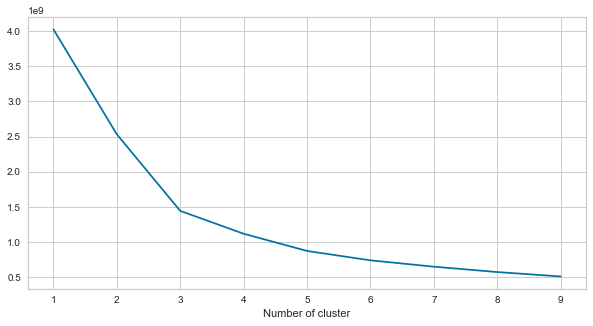

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(list(metric.keys()), list(metric.values()))
plt.xlabel("Number of cluster")
plt.show()

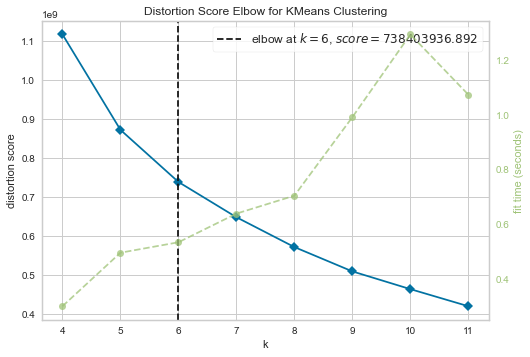

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X_rfm)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

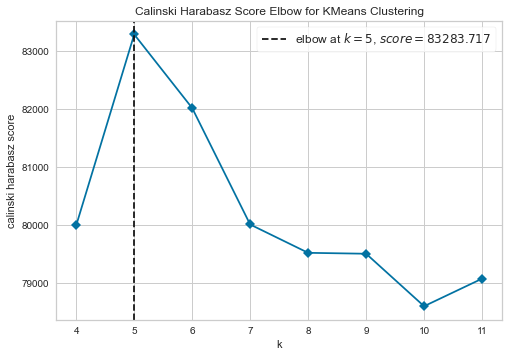

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [17]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12), metric='calinski_harabasz', timings=False)

visualizer.fit(X_rfm)    # Fit the data to the visualizer
visualizer.poof() 

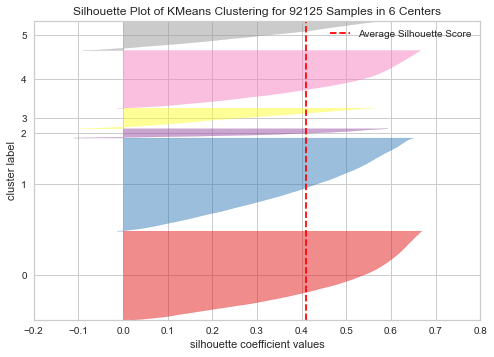

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 92125 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [18]:
# Instantiate the clustering model and visualizer 
model = KMeans(6)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_rfm)    # Fit the data to the visualizer
visualizer.poof()

# PCA

In [19]:
df_normalised

,customer_unique_id,recently_order,cum_sum_order,number_of_orders,customer_state_encode,mean_review_score
0,7c396fd4830fd04220f754e42b4e5bff,0.789166,-0.464899,3.777570,1.149382,0.663862
1,7c396fd4830fd04220f754e42b4e5bff,0.789166,-0.464899,3.777570,1.149382,-0.116841
8,af07308b275d755c9edb36a90c618231,-1.346400,-0.067792,-0.186531,-1.035537,-0.116841
9,3a653a41f6f9fc3d2a113cf8398680e8,-1.442142,0.187240,-0.186531,-1.110879,0.663862
10,7c142cf63193a1473d2e66489a9ae977,0.291675,-0.536817,-0.186531,-1.199632,0.663862
...,...,...,...,...,...,...
126123,6359f309b166b0196dbf7ad2ac62bb5a,1.971667,-0.449594,-0.186531,1.149382,0.663862
126124,da62f9e57a76d978d02ab5362c509660,-0.234843,0.294779,-0.186531,1.149382,-0.116841
126125,737520a9aad80b3fbbdad19b66b37b30,0.841079,0.809515,-0.186531,-1.035537,0.663862
126126,5097a5312c8b157bb7be58ae360ef43c,-0.045670,1.961762,-0.186531,-0.498519,-1.678248


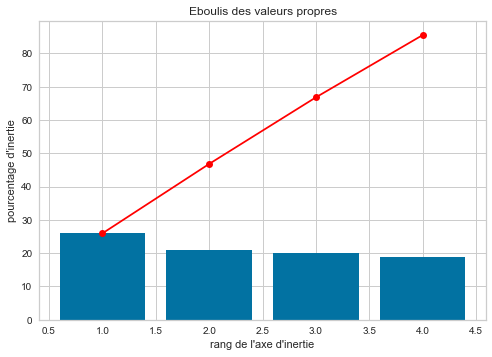

In [20]:
X=df_normalised[['recently_order', 'cum_sum_order', 'number_of_orders', 'mean_review_score', 'customer_state_encode' ]]
N_COMP=4
features=df_normalised[['recently_order', 'cum_sum_order', 'number_of_orders', 'mean_review_score', 'customer_state_encode']].columns

#std_scale = StandardScaler().fit(X)
#X_scaled = std_scale.transform(X)
pca=PCA(n_components=N_COMP)
pca.fit(X)
display_scree_plot(pca)





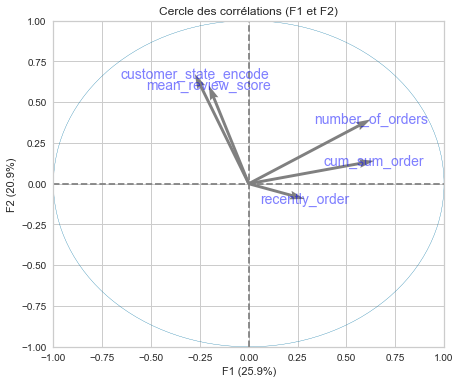

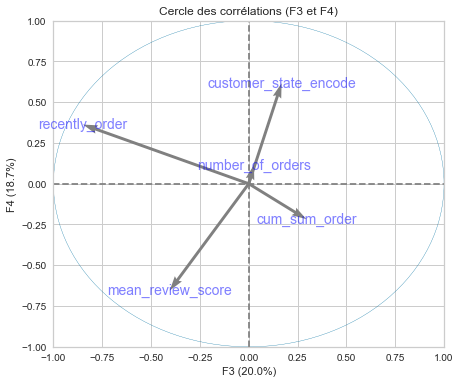

In [21]:
pcs=pca.components_
display_circles(pcs, N_COMP, pca, [(0,1),(2,3),(4,5)], labels=np.array(features))

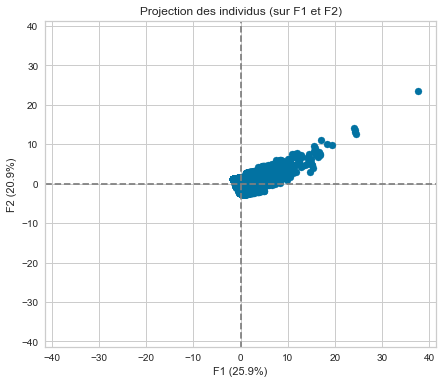

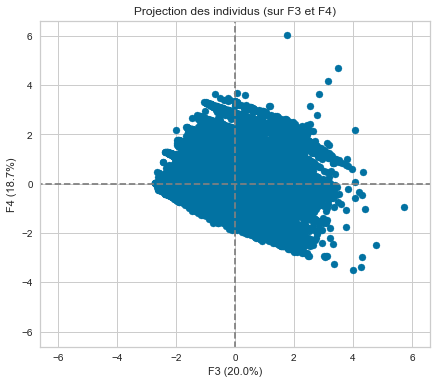

In [22]:
X_projected = pca.transform(X)
display_factorial_planes(X_projected, N_COMP, pca, [(0,1),(2,3),(4,5)],)# labels = np.array(names))

plt.show()

In [23]:
customer_id = df_normalised['customer_unique_id'].reset_index()

In [24]:
df_pca = pd.DataFrame(X_projected)

In [25]:
df_pca= pd.concat([df_pca,customer_id] , axis=1)

# entrainement RFM

In [26]:
k_means = KMeans(n_clusters=5)
k_means.fit(rfm_k_mean[['recently_order', 'cum_sum_order', 'number_of_orders']])
rfm_k_mean["clusters"] = k_means.labels_

In [27]:
rfm_k_mean["clusters"].value_counts()

1    30125
4    29288
3    20295
0     9579
2     2838
Name: clusters, dtype: int64

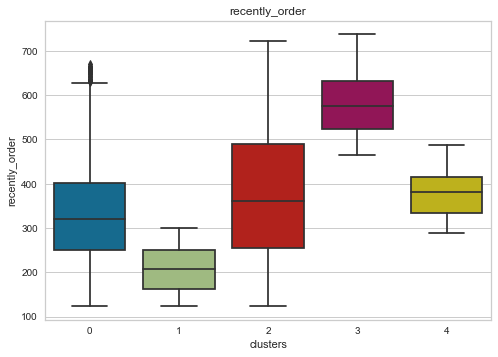

4 --> 378.7335085050164
1 --> 208.49273454087754
3 --> 580.2976173409787
2 --> 378.8522054891615
0 --> 327.7827873521568


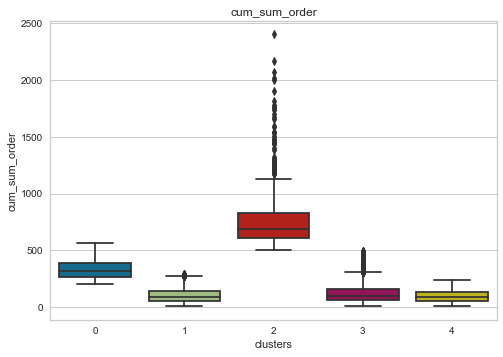

4 --> 96.66210086041984
1 --> 105.71307585062107
3 --> 120.73602611480725
2 --> 733.9237491190985
0 --> 335.2474193548387


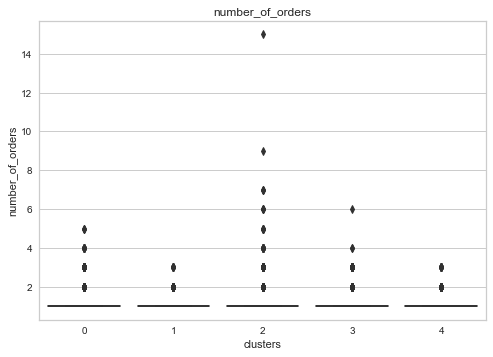

4 --> 1.0194960393335155
1 --> 1.0098589211618256
3 --> 1.0450357230845035
2 --> 1.1670190274841437
0 --> 1.0879006159306817


In [28]:
ploting(rfm_k_mean, ['recently_order', 'cum_sum_order', 'number_of_orders'], 'clusters')

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


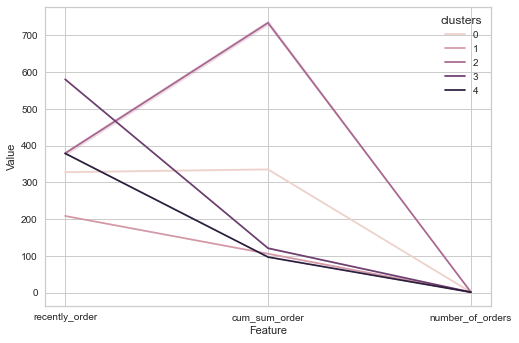

In [29]:
lineploting(rfm_k_mean, ['recently_order',
                     'cum_sum_order',
                     'number_of_orders',
                     ])

In [30]:
test = rfm_k_mean.copy()

<AxesSubplot:xlabel='comp_1', ylabel='comp_2'>

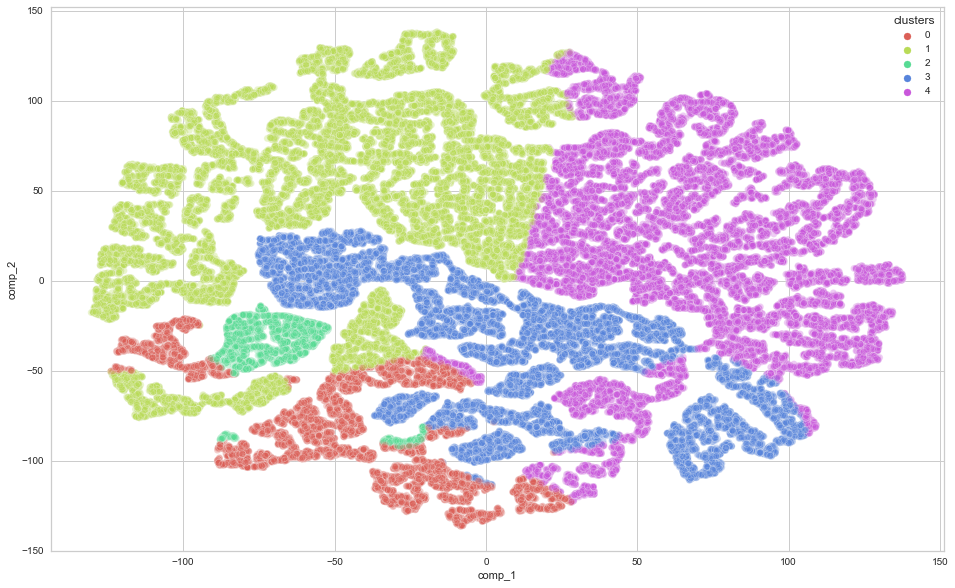

In [31]:
X_embedded = TSNE(n_components=2, learning_rate='auto', 
                  init='random', perplexity=50).fit_transform(rfm_k_mean[['recently_order', 
                                                                          'cum_sum_order', 'number_of_orders']])
test['comp_1'] = X_embedded[:,0]
test['comp_2'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='comp_1', y='comp_2',
    hue="clusters",
    palette=sns.color_palette("hls", 5),
    legend="full",
    data = test,
    alpha=0.3
)

la délimitation est pas terrible sur un TSNE

# RFM avec standardisation

In [32]:
k_means = KMeans(n_clusters=5)
k_means.fit(df_normalised[['recently_order', 'cum_sum_order', 'number_of_orders']])
df_normalised["clusters"] = k_means.labels_

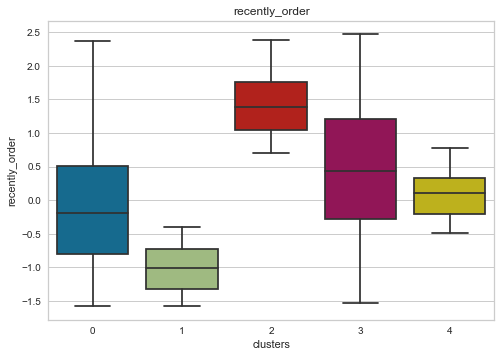

3 --> 0.45847229637115117
1 --> -1.0141433976215664
4 --> 0.09027604061204574
2 --> 1.4157299080089143
0 --> -0.08405686995982879


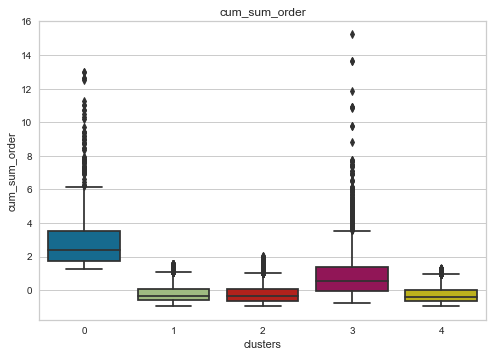

3 --> 0.9220303085215101
1 --> -0.2195299119589183
4 --> -0.26857291253300364
2 --> -0.21680596677285172
0 --> 2.782401705318075


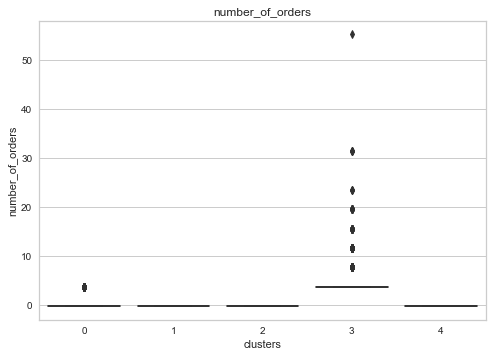

3 --> 4.320125108733247
1 --> -0.18653092209394212
4 --> -0.18653092209394329
2 --> -0.1865309220939793
0 --> -0.13588227141485296


In [33]:
ploting(df_normalised, ['recently_order', 'cum_sum_order', 'number_of_orders'], 'clusters')

permet de différencier un peu mieux le nombre de commandes

In [ ]:
# Instantiate the clustering model and visualizer 

visualizer = SilhouetteVisualizer(KMeans(n_clusters=5))

visualizer.fit(df_normalised[['recently_order', 'cum_sum_order', 'number_of_orders']])    # Fit the data to the visualizer
visualizer.poof()

In [ ]:
a = df_normalised[['recently_order', 'cum_sum_order', 'number_of_orders']]
b = df_normalised['clusters']
silhouette_score(a,b)

# More features

In [ ]:
df

In [ ]:
df_k_mean = df[['customer_unique_id', 'recently_order',
                    'cum_sum_order', 'number_of_orders', 'mean_review_score', 'customer_state_encode']].drop_duplicates()

In [ ]:
X_more_features = df_k_mean[['recently_order',
                    'cum_sum_order', 'number_of_orders', 'mean_review_score',
                            'customer_state_encode']]

In [ ]:
metric={}
for i in range (1, 10):
    k_means = KMeans(n_clusters=i)
    k_means.fit(X_more_features)
    df_k_mean["clusters"] = k_means.labels_
    metric[i] = k_means.inertia_

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(list(metric.keys()), list(metric.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
# Instantiate the clustering model and visualizer 
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_more_features)    # Fit the data to the visualizer
visualizer.poof()

In [ ]:
model = KMeans(n_clusters=5)
model.fit(X_more_features)
df_k_mean["clusters"] = model.labels_
df_k_mean#["clusters"].unique()

In [ ]:
ploting(df_k_mean, ['recently_order',
                     'cum_sum_order',
                     'number_of_orders',
                     'mean_review_score',
                     'customer_state_encode'
                   ],
        'clusters')

In [ ]:
lineploting(df_k_mean, ['recently_order',
                     'cum_sum_order',
                     'number_of_orders',
                     'mean_review_score',
                            'customer_state_encode'])

In [ ]:
df_k_mean["clusters"].value_counts()

## without state

In [ ]:
df_k_mean = df[['customer_unique_id', 'recently_order', 
                    'cum_sum_order', 'number_of_orders', 'mean_review_score']].drop_duplicates()

X_more_features = df_k_mean[['recently_order', 
                    'cum_sum_order', 'number_of_orders', 'mean_review_score']]

In [ ]:
# Instantiate the clustering model and visualizer 
model = KMeans(6)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_more_features)    # Fit the data to the visualizer
visualizer.poof()

In [ ]:
model = KMeans(n_clusters=6)
model.fit(X_more_features)
df_k_mean["clusters"] = model.labels_
df_k_mean#["clusters"].unique()

In [ ]:
ploting(df_k_mean, ['recently_order',
                     'cum_sum_order',
                     'number_of_orders',
                     'mean_review_score',
                     ],
        'clusters')

In [ ]:
lineploting(df_k_mean, ['recently_order',
                     'cum_sum_order',
                     'number_of_orders',
                     'mean_review_score'])

## With normalized data

In [ ]:
df_k_mean_norm = df_normalised[['customer_unique_id', 'recently_order',  
                    'cum_sum_order', 'number_of_orders', 'mean_review_score']].drop_duplicates()

X_more_features_norm = df_k_mean_norm[['recently_order',  
                    'cum_sum_order', 'number_of_orders', 'mean_review_score']]

In [ ]:
# Instantiate the clustering model and visualizer 
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_more_features_norm)    # Fit the data to the visualizer
visualizer.poof()

In [ ]:
model = KMeans(n_clusters=5)
model.fit(X_more_features_norm)
df_k_mean_norm["clusters"] = model.labels_
df_k_mean_norm#["clusters"].unique()

In [ ]:
ploting(df_k_mean_norm, ['recently_order',
                     'cum_sum_order',
                     'number_of_orders',
                     'mean_review_score',
                     ],
        'clusters')

In [ ]:
df_k_mean_norm.clusters.value_counts()

In [ ]:
lineploting(df_k_mean_norm, ['recently_order',
                     'cum_sum_order',
                     'number_of_orders',
                     'mean_review_score'])

In [ ]:
df_k_mean_norm_=df_k_mean_norm.sample(1000)

In [ ]:
df_k_mean_norm_.clusters.value_counts()

In [ ]:
ploting_3d(df_k_mean_norm_, ['recently_order','cum_sum_order','mean_review_score'], 1000)

In [ ]:
a = df_k_mean_norm[['recently_order', 'cum_sum_order', 
                    'number_of_orders', 'mean_review_score']]
b = df_k_mean_norm['clusters']
silhouette_score(a,b)

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans(5)
visualizer = InterclusterDistance(model)

visualizer.fit(df_k_mean_norm[['recently_order',
                     'cum_sum_order',
                     'number_of_orders',
                     'mean_review_score']])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto', 
                  init='random', perplexity=30).fit_transform(df_k_mean_norm[['recently_order',
                     'cum_sum_order',
                     'number_of_orders',
                     'mean_review_score']])

In [ ]:
df_k_mean_norm['comp_1'] = X_embedded[:,0]
df_k_mean_norm['comp_2'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='comp_1', y='comp_2',
    hue="clusters",
    palette=sns.color_palette("hls", 5),
    legend="full",
    data = df_k_mean_norm,
    alpha=0.3
)

## With data pca

In [ ]:


model = KMeans(n_clusters=6)
model.fit(X_projected)
df_pca["clusters"] = model.labels_
df_pca#["clusters"].unique()

In [ ]:
ploting(df_pca, [0,1,2,3,4], 'clusters')

In [ ]:
a = df_pca[[0,1,2,3,4]]
b = df_pca['clusters']
silhouette_score(a,b)

# Clustering hiérarchique

In [ ]:
X=df_normalised
X_reduced = X.sample(int(len(X)/5))
X_hierarchcal = X_reduced[['recently_order', 'cum_sum_order',
       'number_of_orders', 'customer_state_encode', 'mean_review_score']]

In [ ]:
nb_clusters ={}
for i in range (50, 150, 2):
    model = AgglomerativeClustering(n_clusters=None, distance_threshold=i)
    model.fit(X_hierarchcal)
    X_hierarchcal['labels']=model.labels_
    nb_clusters[i]=X_hierarchcal['labels'].nunique()

In [ ]:
for key, value in nb_clusters.items():
    print(key, '----->', value)

In [ ]:
# 99 semble la plus petite value pour attenidre 7 clusters

In [ ]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=120)
model.fit(X_hierarchcal)
X_hierarchcal['clusters']=model.labels_

In [ ]:
X_hierarchcal['clusters'].value_counts()

In [ ]:
test = pd.concat([X_hierarchcal, X_reduced['customer_unique_id']], axis=1)

In [ ]:
test

In [ ]:
lineploting(test, ['recently_order',
                     'cum_sum_order',
                     'number_of_orders',
                     'mean_review_score'])

In [ ]:
ploting(X_hierarchcal, ['recently_order', 'cum_sum_order',
       'number_of_orders', 'customer_state_encode', 'mean_review_score'], 'clusters')

In [ ]:
h=X_hierarchcal.drop(columns='labels')
Z=hierarchy.linkage(h, method="ward")


In [ ]:
figure = plt.figure(figsize=(25, 10))
den = dendrogram(Z)

# DBSCAN

https://medium.com/mlearning-ai/demonstrating-customers-segmentation-with-dbscan-clustering-using-python-8a2ba0db2a2e

In [ ]:
#-1->anomalies

In [ ]:
X_db_scan = X_reduced.drop(columns=['customer_unique_id'])

In [ ]:
clustering = DBSCAN(eps=3, min_samples=100).fit(X_db_scan)
clustering.labels_


In [ ]:
clustering.labels_

In [ ]:
for i in range (2, 100, 2):
    clustering = DBSCAN(eps=i, min_samples=100).fit(X_db_scan)
    col = 'eps'+str(i)
    X_db_scan[col]=clustering.labels_

In [ ]:
X_db_scan['min_sample_2'].value_counts()

In [ ]:
# le DBSCAN ne semble pas pertinent pour créer des clusters fiables

In [ ]:
ploting(X_db_scan, ['recently_order', 'cum_sum_order',
       'number_of_orders', 'customer_state_encode', 'mean_review_score'], 'min_sample_2')